In [1]:
# Data Wrangling Library
import pandas as pd
import os
import plotly.graph_objects as go
# Library for clustering
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# **Clustering IP and Izin**

In [2]:
# Directory for path file
directory = "/Users/efishery/Documents/Statistics Coach/DPMPTSP/Database/dbt_playground/data/"
file_path = [os.path.join(directory, filename) for filename in os.listdir(directory) 
             if filename.endswith('.xlsx') and 'spatialjoin' in filename]

file_path = [path for path in file_path if "(1).xlsx" in path]

In [3]:
# Adding empty list for inputting data from excel
dt = []

# Importing data investasi dan pengawasan
for i in range(0,len(file_path)) :
    dt_temp = pd.read_excel(file_path[i])
    dt.append(dt_temp)
 
dt_ip = pd.concat(dt, ignore_index = True)

In [4]:
dt_ip = dt_ip.drop(dt_ip.columns[[33,34]], axis = 1)

dt_ip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089291 entries, 0 to 1089290
Data columns (total 33 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   Index                            1089291 non-null  int64  
 1   Service_Point                    1089291 non-null  object 
 2   Tahun                            1089291 non-null  int64  
 3   Id_Proyek                        1089291 non-null  object 
 4   Uraian_Jenis_Proyek              1089291 non-null  object 
 5   Nib                              1089291 non-null  int64  
 6   Nama_Perusahaan                  1089235 non-null  object 
 7   Tanggal_Terbit_Oss               1089291 non-null  object 
 8   Uraian_Status_Penanaman_Modal    1089291 non-null  object 
 9   Uraian_Jenis_Perusahaan          1089237 non-null  object 
 10  Uraian_Risiko_Proyek             1089291 non-null  object 
 11  nama_proyek                      1048832 non-null 

In [9]:
# Transform data into crosstab
filtered_dt_ip = dt_ip[dt_ip['Kota'].isin(['Jakarta Selatan','Jakarta Utara','Jakarta Barat','Jakarta Timur','Jakarta Pusat','Kepulauan Seribu'])]

# Definisikan kolom-kolom yang akan digunakan sebagai index, columns, dan values
# Setiap elemen dalam list adalah tuple dengan format: (index, columns, values, aggfunc)
crosstab_params = [
    (['Kota', 'Kecamatan', 'Kelurahan'], 'Uraian_Status_Penanaman_Modal', None, None),
    (['Kota', 'Kecamatan', 'Kelurahan'], 'Uraian_Status_Penanaman_Modal', 'Jumlah_Investasi', 'sum'),
    (['Kota', 'Kecamatan', 'Kelurahan'], 'Uraian_Jenis_Perusahaan', None, None),
    (['Kota', 'Kecamatan', 'Kelurahan'], 'Uraian_Jenis_Perusahaan', 'Jumlah_Investasi', 'sum'),
    (['Kota', 'Kecamatan', 'Kelurahan'], 'Uraian_Skala_Usaha', None, None),
    (['Kota', 'Kecamatan', 'Kelurahan'], 'Uraian_Skala_Usaha', 'Jumlah_Investasi', 'sum'),
    (['Kota', 'Kecamatan', 'Kelurahan'], 'Uraian_Risiko_Proyek', None, None),
    (['Kota', 'Kecamatan', 'Kelurahan'], 'Uraian_Risiko_Proyek', 'Jumlah_Investasi', 'sum'),
    (['Kota', 'Kecamatan', 'Kelurahan'], 'Uraian_Jenis_Proyek', None, None),
    (['Kota', 'Kecamatan', 'Kelurahan'], 'Uraian_Jenis_Proyek', 'Jumlah_Investasi', 'sum'),
    (['Kota', 'Kecamatan', 'Kelurahan'], 'KL_Sektor_Pembina', None, None),
    (['Kota', 'Kecamatan', 'Kelurahan'], 'KL_Sektor_Pembina', 'Jumlah_Investasi', 'sum'),
]

# Dictionary untuk menyimpan hasil dari setiap crosstab
crosstab_results = {}

# Loop untuk membuat crosstab berdasarkan parameter yang didefinisikan
for i, (index, columns, values, aggfunc) in enumerate(crosstab_params, start=1):
    ct_name = f'ct_{i}'
    
    if values is None:
        crosstab_results[ct_name] = pd.crosstab(index=[filtered_dt_ip[col] for col in index],
                                                columns=filtered_dt_ip[columns])
    else:
        crosstab_results[ct_name] = pd.crosstab(index=[filtered_dt_ip[col] for col in index],
                                                columns=filtered_dt_ip[columns],
                                                values=filtered_dt_ip[values],
                                                aggfunc=aggfunc)
    
    crosstab_results[ct_name].reset_index(inplace=True)

# Menghitung jumlah investasi dengan groupby
total_investasi = filtered_dt_ip.groupby(['Kota', 'Kecamatan', 'Kelurahan'])['Jumlah_Investasi'].sum().reset_index()

In [10]:
# Menggabungkan seluruh tabel crosstab ke dalam satu tabel besar
combined_crosstab = crosstab_results['ct_1']

# Gabungkan crosstab lainnya
for ct_name in list(crosstab_results.keys())[1:]:
    combined_crosstab = combined_crosstab.merge(crosstab_results[ct_name], on=['Kota', 'Kecamatan', 'Kelurahan'], how='outer', suffixes=('', '_y'))

# Menghapus kolom yang tidak diperlukan setelah penggabungan
combined_crosstab = combined_crosstab.loc[:,~combined_crosstab.columns.duplicated()]

# Menggabungkan total_investasi ke dalam combined_crosstab
final_combined = combined_crosstab.merge(total_investasi, on=['Kota', 'Kecamatan', 'Kelurahan'], how='inner')

# **Clustering Izin**

In [14]:
# Directory for path file izin
path_izin = "/Users/efishery/Documents/Statistics Coach/DPMPTSP/Database/dbt_playground/data/data_izin.xlsx"

dt_izin = pd.read_excel(path_izin)

In [26]:
ct_izin = pd.crosstab(
    index = [dt_izin['level_wilayah'], dt_izin['recode_wilayah']]
    , columns = dt_izin['Bidang_Recode']
    , values = dt_izin['total_selesai']
    , aggfunc = 'sum'
)

ct_izin.reset_index(inplace = True)
ct_izin_kel = ct_izin[ct_izin['level_wilayah'].isin(['KEL'])]
ct_izin_kec = ct_izin[ct_izin['level_wilayah'].isin(['KEC'])]

In [49]:
# Kombinasikan antara ct_izin dan ct_investasi (final_combined)
ct_comb = final_combined.merge(ct_izin_kel, left_on=['Kelurahan'], right_on=['recode_wilayah'], how='inner')
ct_comb = ct_comb.drop(ct_comb.columns[[114,115]], axis = 1)

# Menyimpan hasil ke file Excel tanpa merge cell pada index
ct_comb.to_excel('output_combined_crosstab.xlsx', index=False)

# Clustering KMeans

/var/folders/qj/vt4rcyh91s35vhsqftj_6fhh0000gn/T/ipykernel_4041/2908613592.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ct_comb_alt = ct_comb_alt.fillna(0)


<Axes: >

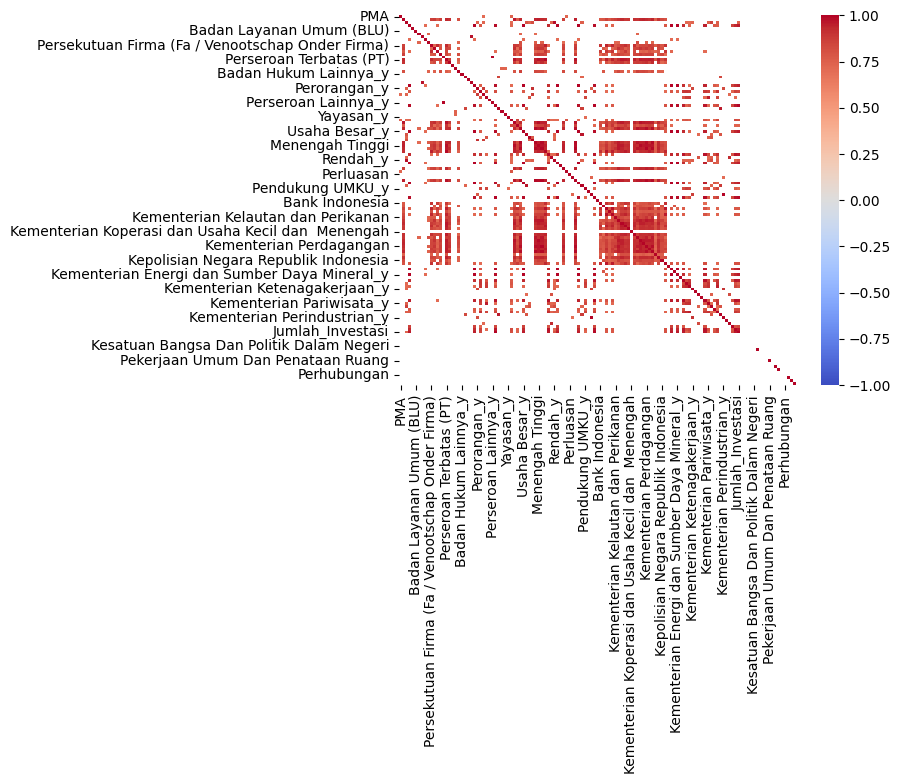

In [64]:
# Data preparation buat masuk ke kmeans
ct_comb_alt = ct_comb.drop(ct_comb.columns[[0,1,2]], axis = 1)
ct_comb_alt = ct_comb_alt.fillna(0)

# Melakukan pengecekan clustering
corr_mat = ct_comb_alt.corr()

strong_corr = corr_mat[(corr_mat > 0.7 ) | (corr_mat < -0.7)]

sns.heatmap(strong_corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1)


# sns.heatmap(corr_matx, annot = False, cmap = 'coolwarm', vmin = = -1, vmax =1)


In [57]:
inertia = []
centroids = []
K = range(1, 100)
for k in K : 
    kmeans = KMeans(n_clusters = k, random_state=42)
    kmeans.fit(ct_comb_alt)
    inertia.append(kmeans.inertia_)

Kmeans menghasilkan 2 cluster pada setiap 

/var/folders/qj/vt4rcyh91s35vhsqftj_6fhh0000gn/T/ipykernel_4041/582140726.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ct_comb_alt = ct_comb_alt.fillna(0)


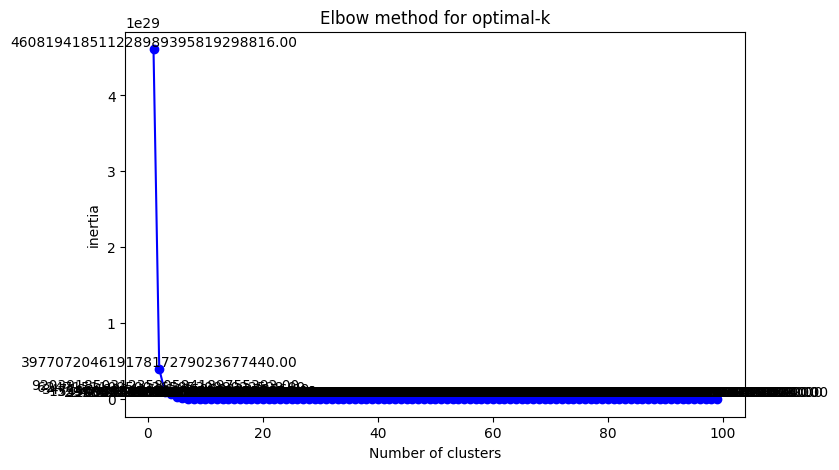

In [58]:
plt.figure(figsize = (8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('inertia')
plt.title('Elbow method for optimal-k')

for i, value in enumerate(inertia):
    plt.text(K[i], inertia[i], f'{value:.2f}', fontsize=10, ha='center', va='bottom')  # .2f for two decimal places

plt.show()

In [35]:
optimal_k = 8

kmeans = KMeans(n_clusters = optimal_k, random_state=42)
ct_izin['Cluster'] = kmeans.fit_predict(ct_izin)

# Combining cluster with only 1 member in it
ct_izin['Cluster'] = ct_izin['Cluster'].replace(2, 7)
ct_izin['Cluster'] = ct_izin['Cluster'].replace(5, 0)


<Axes: xlabel='Bidang_Recode', ylabel='Cluster'>

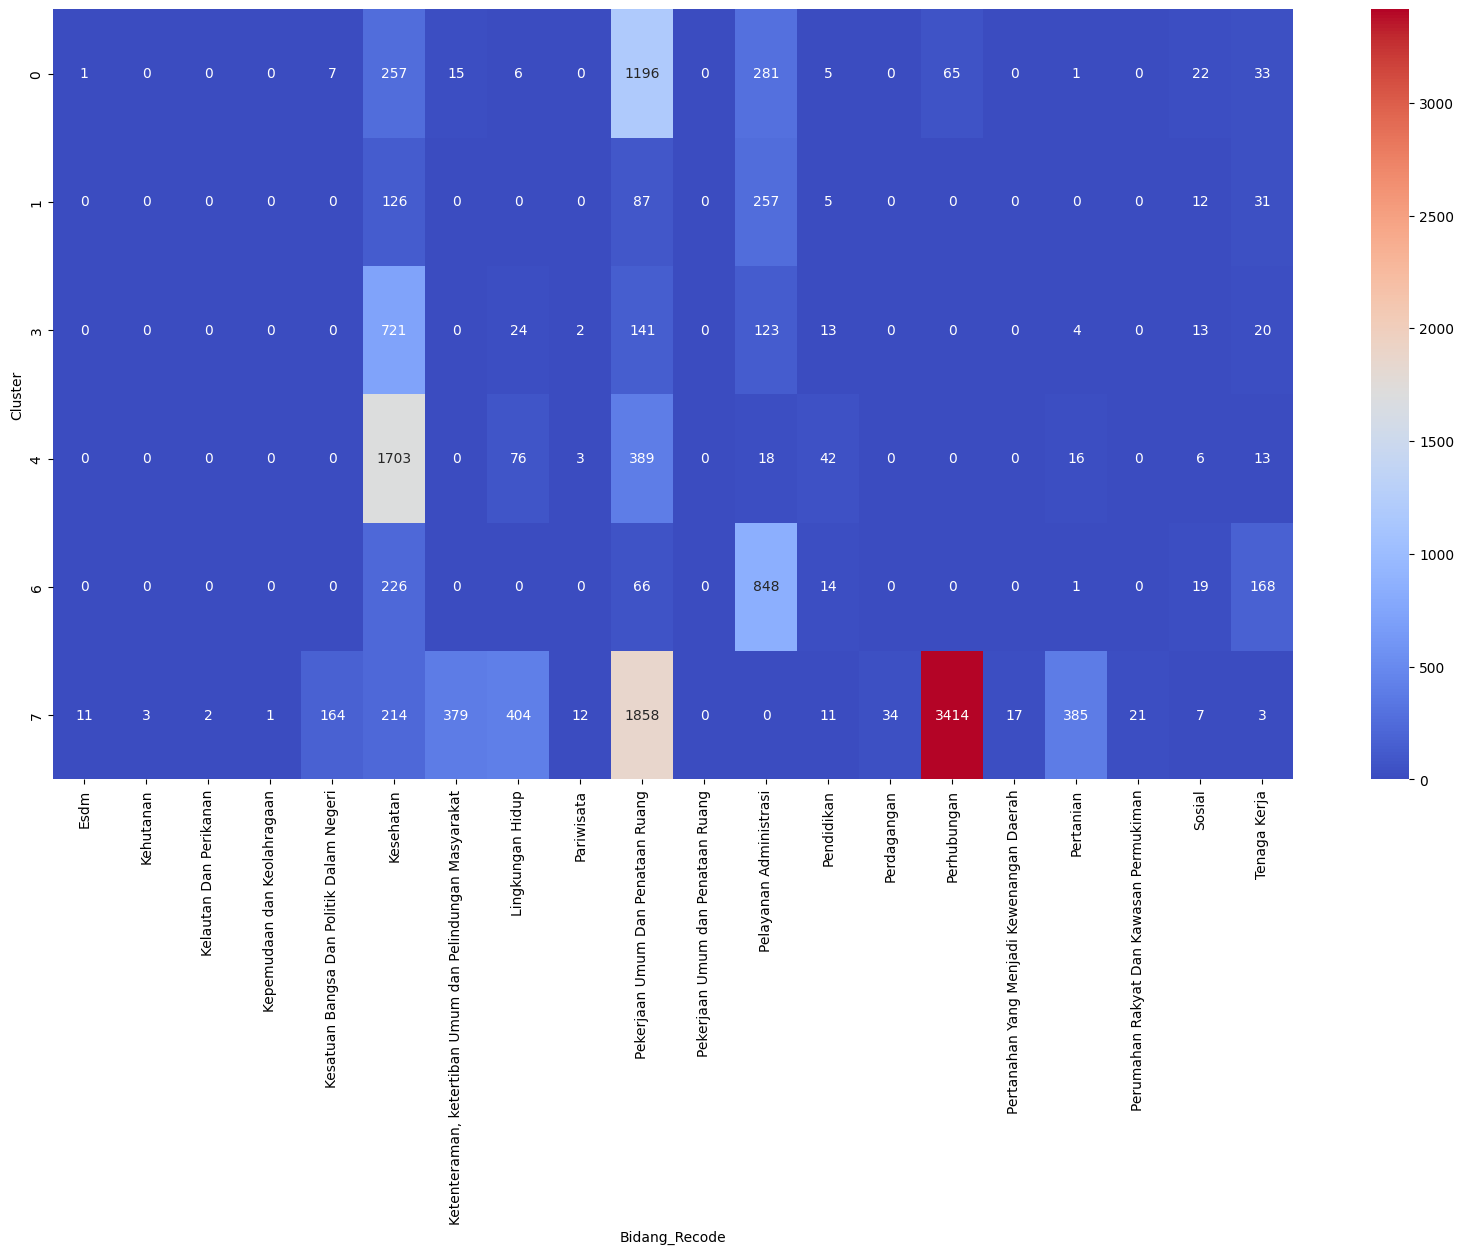

In [40]:
# ct_izin.groupby('Cluster').mean()
plt.figure(figsize =(20,10))
sns.heatmap(ct_izin.groupby('Cluster').mean(), annot = True, fmt=".0f", cmap ='coolwarm')

In [39]:
ct_izin['Cluster'].value_counts()

Cluster
1    208
3     47
4     22
6     18
0     16
7      5
Name: count, dtype: int64

In [15]:
ct_izin.info()

<class 'pandas.core.frame.DataFrame'>
Index: 316 entries, DPMPTSP DKI JAKARTA to Kantor Walikota Jakarta Utara
Data columns (total 21 columns):
 #   Column                                                    Non-Null Count  Dtype
---  ------                                                    --------------  -----
 0   Esdm                                                      316 non-null    int64
 1   Kehutanan                                                 316 non-null    int64
 2   Kelautan Dan Perikanan                                    316 non-null    int64
 3   Kepemudaan dan Keolahragaan                               316 non-null    int64
 4   Kesatuan Bangsa Dan Politik Dalam Negeri                  316 non-null    int64
 5   Kesehatan                                                 316 non-null    int64
 6   Ketenteraman, ketertiban Umum dan Pelindungan Masyarakat  316 non-null    int64
 7   Lingkungan Hidup                                          316 non-null    int64
 8   P

In [43]:
# Save cluster into excel 
ct_izin['Cluster'].to_excel('ct_izin2.xlsx', index = True)

In [41]:
dw1df = pd.read_excel('ct_izin.xlsx', sheet_name = 'lvlderivative')

In [6]:
df = pd.DataFrame(data)

In [39]:
pivot_df = df.pivot_table(index='district', columns='bidang', values='izin_yang_selesai', fill_value=0)
# pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100  # Convert to percentage
# pivot_df = pivot_df.reset_index()

In [35]:
fig = go.Figure()
for bidang_category in pivot_df.columns[1:]:  # Skip the first column 'district'
    fig.add_trace(go.Bar(
        x=pivot_df[bidang_category],
        y=pivot_df['district'],
        name=bidang_category
        , orientation = 'h'
    ))